**Name:** Mayank Goel

**Roll no:** 2021110311

**Cell Outputs**:

Task 1.1: Cell [4] \
Task 1.2: Cell [10], [11] \
Task 1.3: Cell [13] \
Task 1.4: Cell [14] \
Task 2.1: Cell [16], [18] \
Task 2.2: Cell [22] \
Task 2.3: Cell [25] \
Task 3.1: Cell [26] \
Task 3.2: Cell [29]

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Task 1 - Own Calibration

## Task 1.1: Finding chessboard corners

For the given image calib-object.jpg, identify the chessboard internal corners. You may use external libraries to detect the chessboard corners. Note, each square of the chess board is 2cm ×2cm.

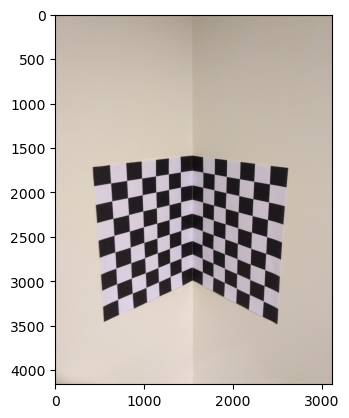

In [2]:
def display_image(img, title=None):
    """
    Function to display an image using matplotlib. Title is specifiable as an optional argument
    """
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    if title:
        plt.title(title)
    plt.show()
    
img = cv.imread('calib-object.jpg')
width, height = img.shape[1], img.shape[0]
display_image(img)

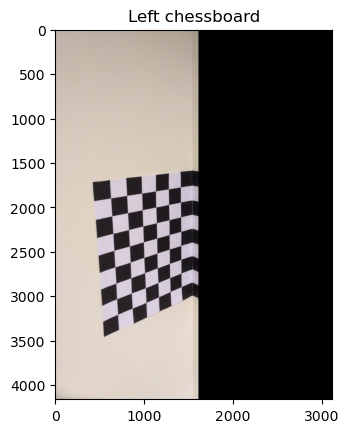

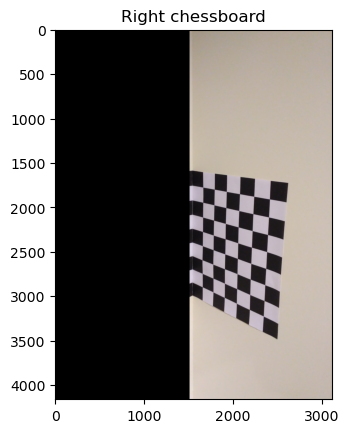

In [3]:
OFFSET = 50

# Finding corners in the left chessboard
left_img = img.copy()
left_img[:, OFFSET + (img.shape[1]//2):] = 0
left_corners = cv.findChessboardCorners(left_img, (8,6))[1].astype(int).squeeze()

# Finding corners in the right chessboard
right_img = img.copy()
right_img[:, :img.shape[1]//2 - OFFSET] = 0
right_corners = cv.findChessboardCorners(right_img, (8,6))[1].astype(int).squeeze()

corners = np.append(left_corners, right_corners, axis=0)

display_image(left_img, 'Left chessboard')
display_image(right_img, 'Right chessboard')

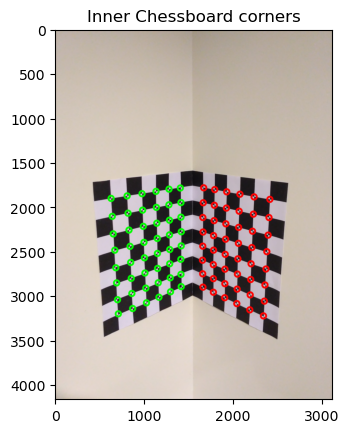

In [4]:
RADIUS = 30
COLOR = (0, 255, 0)

def drawPoints(img : np.ndarray, centre_coord, radius=RADIUS, color=COLOR, thickness=20):
    """
    Function to plot a point as a circle on the specified image
    color is in BRG format and radius, thickness is a float
    """
    cv.circle(img, centre_coord, radius, color, thickness)


# Drawing corners on the left half of the chessboard 
img_corner = img.copy()
for corner in left_corners:
    drawPoints(img_corner, tuple(corner))
    
# Drawing corners on the right half of the chessboard    
for corner in right_corners:
    drawPoints(img_corner, tuple(corner), color=(0, 0, 255))
    
display_image(img_corner, 'Inner Chessboard corners')

**Observation** : `findChessCorners()` function does not work on the image as a whole beaucse the image contained two Chessboards having different orienatations. So I blackout the right half to get the corners in the left Chessboard and vice versa.

I converted the Chessboard corner array to integer and plotted the internal corners on the orignal image using the cv.circle() function. This methodology seems to perfectly detect the inner corners as displayed above.

## Task 1.2: Own Camera Calibration 

Implement the camera calibration process discussed in the lecture. Assume a world origin, create a
set of corresponding points in the world coordinate and image plane, compute both extrinsics (translation vector,
rotation matrix) and intrinsics (assume no skew) without using any external libraries for the calib-object.jpg
image.

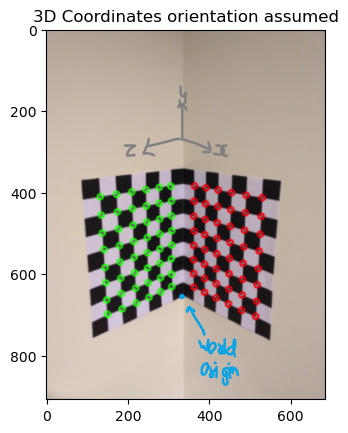

In [5]:
orientation = cv.imread('Orientation.png')
display_image(orientation, '3D Coordinates orientation assumed')

In [6]:
# Creating an array of world coordinates of both the Chessboards (assuming the above mentioned Orientation and origin)
x = np.arange(2, 14, 2)
y = np.arange(2, 18, 2)
X, Y = np.meshgrid(x,y)
X, Y = X.T, Y.T
zero = np.zeros(len(X.flatten()))

left_half_wcoord = np.array([zero, Y.flatten()[::-1], X.flatten()]).T
right_half_wcoord = np.array([X.flatten(),Y.flatten(), zero]).T

world_coordinates = np.append(left_half_wcoord, right_half_wcoord, axis=0)
#print(world_coordinates)

In [7]:
def rq_decomposition(A: np.ndarray) -> (np.ndarray, np.ndarray):
    '''Implementing rq decomposition using QR decomposition

     The RQ decomposition transforms a matrix A into the product of an upper triangular matrix R (also known as right-triangular) and an orthogonal matrix Q. The only difference from QR decomposition is the order of these matrices.
     QR decomposition is Gram-Schmidt orthogonalization of columns of A, started from the first column.
     RQ decomposition is Gram-Schmidt orthogonalization of rows of A, started from the last row.
    
     Parameters: A - Matrix to be decomposed
     return value R,Q - R is the upper triangular matrix, Q is the orthonormal matrix
    '''
    
    # Reverse the rows
    reversed_A = np.flipud(A)
 
    # Transposing the matrix and, then find QR
    Q, R = np.linalg.qr(reversed_A.T)
 
    # Reversing the transpose
    R = R.T
    Q = Q.T
    
    # Reversing the flipping (equivalent of multiplying by a pre-matrix)
    R = np.flipud(R)
 
    return R[:,::-1],Q[::-1,:]

In [8]:
class CameraCalibration():
    def __init__(self, w_coord: np.ndarray, img_coord: np.ndarray):
        """
        Initializing a Camera calibration system with support for forwardProjection and backward projection.
        To initialize the camera calibration system, 2D numpy array World coordinates (3D points) and Image coordinates must be specified.
        """
        
        assert len(w_coord) == len(img_coord), "Number of World coordinate points must be equal to Number of Image coordinate points"
        assert w_coord.shape[1] == 3, "World coordinates must be in 3D"
        assert img_coord.shape[1] == 2, "Image coordinates must be in 2D"
        
        self.num_pts = len(w_coord)
        self.calibrated = None
        self.wCoord = w_coord
        self.imgCoord = img_coord
        self.ProjMat = None
        self.calibMat = None
        self.rotMat = None
        self.transVec = None
    
    
    def calibrate(self):
        """
        Function to calibrate the camera.
        """
        
        # Computing the A matrix (refernce Shree Nayar's video lectures)
        A = np.ones((2*self.num_pts, 12))
        
        for i in range(self.num_pts):
            # First row
            A[2*i, 0:3] = self.wCoord[i]
            A[2*i, 4:8] = 0
            A[2*i, 8:11] = self.wCoord[i]
            A[2*i, 8:] *= -self.imgCoord[i][0]
            
            # Second row
            A[2*i + 1, 0:4] = 0
            A[2*i + 1, 4:7] = self.wCoord[i]
            A[2*i + 1, 8:11] = self.wCoord[i]
            A[2*i + 1, 8:] *= -self.imgCoord[i][1]

        # Computing the Eigenvectors of A'A, thus the projection matrix
        U, S, V = np.linalg.svd(A)
        P = V[-1].reshape(3, 4)
        self.ProjMat = P
        t = P[:,3].copy()
        
        # Decomposing the Projection Matrix into Intrinsic and Extrinisc matrices
        K, R = rq_decomposition(P[:,:3])
        K = K/K[2][2]
        
        # Ensuring the focal lengths are positive 
        for i in range(2,-1,-1):
            if(K[i][i] < 0):
                K[i][:i+1] *= -1
                R[i] *= -1
        
        self.calibMat = K
        self.rotMat = R
        self.calibrated = True
        self.transVec = np.linalg.inv(K) @ t.reshape(-1,1)
        
        #print(K, R@R.T)
        #print(self.calibMat @ np.append(self.rotMat, self.transVec.reshape(-1,1), axis=1))
    
    
    def forwardProjection(self, wcoord):
        """
        Given the calibrated camera and the world coordinate of the point, return the Image coordinate
        """
        assert self.calibrated is not None, "The camera must be calibrated using the calibrate() function first"
        
        homogenous_wcoord = np.append(wcoord, np.ones(len(wcoord)).reshape(-1,1), axis=1)
        u = self.ProjMat @ homogenous_wcoord.T
        u /= u[2]
        return u[:2].T
    
    
    def backwardProjection(self, image_coord):
        """
        Given the pixel values (u,v), return the woorld coordinates of that point
        """
        
        x = np.append(image_coord, np.ones(len(image_coord)).reshape(-1,1), axis=1)
        I = np.linalg.inv(self.ProjMat.T @ self.ProjMat) @ self.ProjMat.T @ x
        return I/I[2]

In [9]:
camera = CameraCalibration(world_coordinates, corners)
camera.calibrate()

In [10]:
print("Projection Matrix:\n", camera.ProjMat, "\n")
print("Calibration Matrix:\n", camera.calibMat, "\n")
print("Translation Vector:\n", camera.transVec, "\n")
print("Rotation Matrix:\n", camera.rotMat, "\n")

Projection Matrix:
 [[-9.41370564e-03  2.23120399e-03  2.33513853e-02 -4.57413415e-01]
 [ 4.69334255e-03  2.53800907e-02  4.69554293e-03 -8.88507609e-01]
 [ 4.34652554e-06  1.41643880e-06  4.21572251e-06 -2.96884321e-04]] 

Calibration Matrix:
 [[ 3.74939926e+03  1.80237546e+01  1.56930440e+03]
 [-0.00000000e+00  3.73093583e+03  1.96903061e+03]
 [-0.00000000e+00 -0.00000000e+00  1.00000000e+00]] 

Translation Vector:
 [[ 2.65555225e-06]
 [-8.14630182e-05]
 [-2.96884321e-04]] 

Rotation Matrix:
 [[ 0.69549081  0.00432127 -0.718522  ]
 [ 0.16659069 -0.97370425  0.1553949 ]
 [-0.69895642 -0.2277748  -0.67792224]] 



In [11]:
# Checking whether the rotation matrix is orthonormal
camera.rotMat @ camera.rotMat.T

array([[ 1.00000000e+00,  2.68924158e-17, -1.61997623e-16],
       [ 2.68924158e-17,  1.00000000e+00, -3.30340046e-17],
       [-1.61997623e-16, -3.30340046e-17,  1.00000000e+00]])

**Observation** : Calculated the Projection matrix using the Image and World by the procedure presented by Shree Nayar in his lecture series with the replacement of using SVD in place of calculating eigenvalues of $A^TA$. Decomposed the matrix $P=KM_{\text{ext}}$ as follows:

Let $P_{1:3}$ denote the matrix consisting of first 3 column vectors of the Projection matrix P. Now, $P_{1:3} = KR$ where K is the calibration matrix and R is the rotation matrix. I used the RQ decomposition (customly implemented) to do this factorization.$P_4 = Kt$ where $P_4$ is the 4th column of the Projection Matrix and $t$ is the translation vector. $\implies t = K^{-1}P_4$. 

The $R\cdot R^T = I$ as calculated above (ignore the numerical error of order $10^{-17}$). Indicating, the calibration process was successfully done.

## Task 1.3 Wireframe Overlay

Use the real-world measurements along with the estimated camera parameters to compute the image of a wireframe of the object (Hint: the wireframe is the outer corners of the actual chessboard pattern and has 6 points). Note that you should compute the location of image points as xi = P Xi, where P is the projection matrix computed above. Overlay (draw) the wireframe over the actual image of the object using straight lines between the computed points xi. What do you observe about the overlay?

In [12]:
def plotWireFrame(wireframe_coord: np.ndarray, img: np.ndarray, color=(0, 255, 0), thickness=10):
    """
    Function to plot the wireframe given the boundary corners and the image.
    color is in BRG format and thickness is a float.
    """
    
    wireframe = img.copy()
    n = len(wireframe_coord)
    
    wireframe_coord = wireframe_coord.astype(np.int32)
    for i in range(n):
        cv.line(wireframe, wireframe_coord[i], wireframe_coord[(i+1)%n], color=color, thickness=thickness)
    display_image(wireframe)

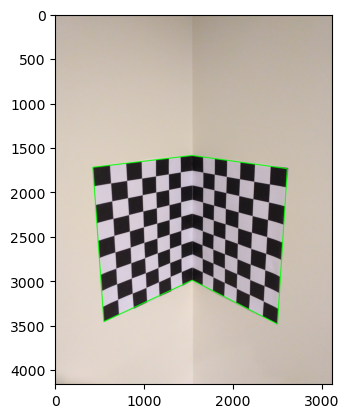

In [13]:
wireframe_points = np.array([[0, 0, 0],
                             [14, 0, 0],
                             [14, 18, 0],
                             [0, 18, 0],
                             [0, 18, 14],
                             [0, 0, 14]], dtype=np.float32)

wireframe_coord = camera.forwardProjection(wireframe_points)
plotWireFrame(wireframe_coord, img)

**Observation** : The wiredrawn infered using the Projection Matrix matches the actual boundary of the Chessboard. Indicating the camera was properly calibrated

## Task 1.4

Given the rotation matrix, compute the three rotation angles. Explain the values that you obtain in terms of pan, tilt, and roll?

In [14]:
R = camera.rotMat

# Calculating pan, roll and tilt
pan = np.rad2deg(np.arctan2(R[2, 1], R[2, 2]))
tilt = np.rad2deg(np.arctan2(R[2, 0], np.sqrt(R[2, 1] ** 2 + R[2, 2] ** 2)))
roll = np.rad2deg(np.arctan2(R[1, 0], R[0, 0]))

print("Pan:", pan)
print("Tilt:", tilt)
print("Roll:", roll)

Pan: -161.42818835017616
Tilt: -44.34333738831271
Roll: 13.4702511328871


- Pan is akin to turning your head from side to side without tilting it up or down

- Tilt is similar to nodding your head up and down while keeping it level

- Roll is analogous to rolling your head from one shoulder to the other without changing the direction you are facing.

Thus, pan, tilt and roll describe the rotation about along the 3 orthogonal axis. Thereby, specifying the rotation matrix and the unit 3D rotational vector.

# Task 2

## Task 2.1 Camera Calibration using OpenCV

Now repeat the camera calibration process for calib-object.jpg using OpenCV calibration functions, continue to assume that there is no skew or distortion (Hint: see calibrateCamera() FLAGS). How does
your result compare with Q1 above? Repeat the overlay of the wireframe using the new parameters. Describe
your observations.

In [15]:
flags = cv.CALIB_ZERO_TANGENT_DIST | cv.CALIB_USE_INTRINSIC_GUESS | cv.CALIB_FIX_K1 | cv.CALIB_FIX_K2 | cv.CALIB_FIX_K3 | cv.CALIB_FIX_K4 | cv.CALIB_FIX_K5 | cv.CALIB_FIX_K6

initialCalibMatrix = np.array([[width, 0, width / 2],
                               [0, height, height / 2],
                               [0, 0, 1]], dtype=np.float32)

RMS, K, distortion_coeff, rotVec, transVec = cv.calibrateCamera([world_coordinates.astype(np.float32)],  [corners.astype(np.float32)], imageSize=(width, height) , cameraMatrix=initialCalibMatrix, distCoeffs=None, flags=flags)
rotVec, transVec = rotVec[0], transVec[0]
rotMat = cv.Rodrigues(rotVec)[0]

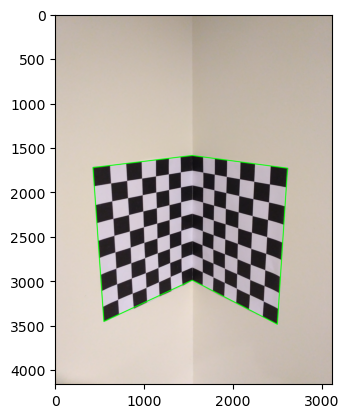

In [16]:
wireframeCoord = cv.projectPoints(wireframe_points.astype(np.float32), rotVec, transVec, K, distortion_coeff)[0]
plotWireFrame(wireframeCoord.squeeze(), img)

In [17]:
def calculateProjectionMatrix(K : np.ndarray, R : np.ndarray, t : np.ndarray) -> np.ndarray:
    """
    Function to calculate the projection matrix given the Calibration and Rotation Matrix 
    and the translation vector
    
    Parameters: K, R, t
    """
    P = K @ np.append(R, np.array(t).reshape(-1,1), axis=1)
    P /= np.sqrt(np.linalg.norm(P@P.T, 'fro'))
    return P

In [18]:
print("Calibration Matrix:\n", K, "\n")
print("Rotation Matrix:\n", rotMat, "\n")
print("Translation vector:\n", transVec, "\n")
print("Projection Matrix:\n", calculateProjectionMatrix(K, rotMat, transVec))

Calibration Matrix:
 [[3.74331131e+03 0.00000000e+00 1.53680477e+03]
 [0.00000000e+00 3.72529660e+03 1.97448237e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 

Rotation Matrix:
 [[ 0.68691105 -0.00126236 -0.7267404 ]
 [ 0.16549919 -0.97345166  0.15811984]
 [-0.70764626 -0.22888921 -0.66846579]] 

Translation vector:
 [[ 0.05252931]
 [13.0317659 ]
 [47.67950747]] 

Projection Matrix:
 [[ 9.24168692e-03 -2.22030677e-03 -2.33421252e-02  4.57602040e-01]
 [-4.86248887e-03 -2.54013258e-02 -4.55187520e-03  8.88721623e-01]
 [-4.40747464e-06 -1.42560407e-06 -4.16344462e-06  2.96965070e-04]]


**Observation** : When comparing the wireframe produced with custome Camera Calibration, no noticable difference is observed. When comparing the individual matrices - projection, calibration, rotation matrices obtained using both the methods, they turn out to be are very close. Custom calibration indicates a very slight skew whereas the openCV does not.

## Task 2.2 Calibrating another image

Repeat Q2.1, for the second image assign1.jpg. Does the wireframe overlay show significant distortions? Comment. What can we say about the computed projection matrix when trying to do calibration based
on world coordinate points that are co-planar? (Hint: we looked at co-planar points in two-view geometry).

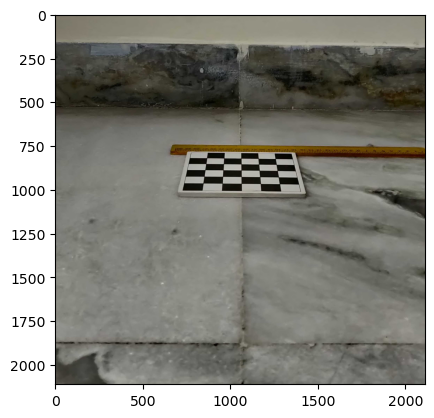

In [19]:
img2 = cv.imread('assign1.jpg')
display_image(img2)

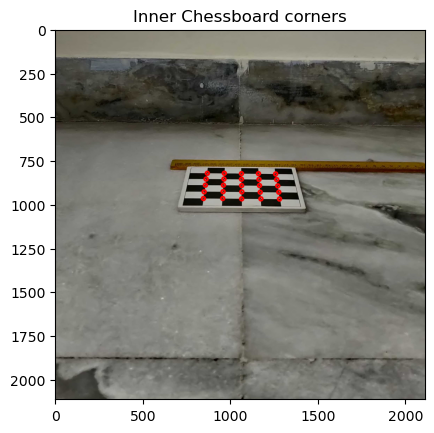

In [20]:
gray = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
corners = cv.findChessboardCorners(gray, (5,5))[1].squeeze().astype(int)

# Drawing corners on the right half of the chessboard    
img_corner = img2.copy()
for corner in corners:
    drawPoints(img_corner, tuple(corner), color=(0, 0, 255), radius=10, thickness=10)
    
display_image(img_corner, 'Inner Chessboard corners')

In [21]:
# Calibrating the camera using OpenCV
world_coord2_pts = np.array([[2,10,0],[4,10,0], [6,10,0], [8,10,0], [10,10,0],
                             [2,8,0],[4,8,0], [6,8,0], [8,8,0], [10,8,0],
                             [2,6,0],[4,6,0], [6,6,0], [8,6,0], [10,6,0],
                             [2,4,0],[4,4,0], [6,4,0], [8,4,0], [10,4,0],                   
                             [2,2,0],[4,2,0], [6,2,0], [8,2,0], [10,2,0]], dtype=np.float32)


width2, height2 = img2.shape[1], img2.shape[0]
initialCalibMatrix2 = np.array([[width2, 0, width2 / 2],
                               [0, height2, height2 / 2],
                               [0, 0, 1]], dtype=np.float32)

RMS, K, distortion_coeff, rotVec, transVec = cv.calibrateCamera([world_coord2_pts],  [corners.astype(np.float32)], (width, height) , cameraMatrix=initialCalibMatrix2, distCoeffs=None, flags=flags)
rotVec = rotVec[0]
transVec = transVec[0]

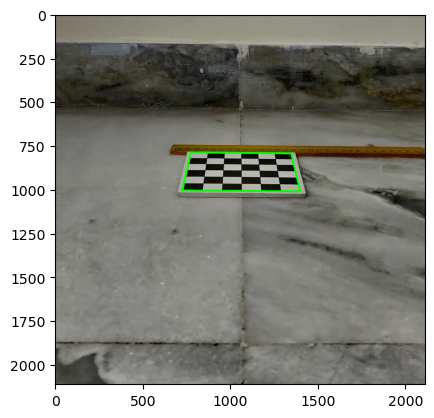

In [22]:
# Displaying the wireframe using the wire
wireframe2_pts = np.array([[0, 0, 0],
                           [12, 0, 0],
                           [12, 12, 0],
                           [0, 12, 0]], dtype=np.float32)

wireframe2Coord = cv.projectPoints(wireframe2_pts, rotVec, transVec, K, distortion_coeff)[0]
plotWireFrame(wireframe2Coord.squeeze(), img2)

**Observation** : There is no significant observable distortion in the wireframe overlay.

## Taske 2.3 World origin

What is the image of the world origin, given the calibration matrix? Does this result agree with your observations?

In [23]:
# Calculating the projection Matrix
R_x = [[1, 0, 0],
       [0, np.cos(rotVec[0])[0], -np.sin(rotVec[0])[0]],
       [0, np.sin(rotVec[0])[0], np.cos(rotVec[0])[0]]]

R_y = [[np.cos(rotVec[1])[0], 0, np.sin(rotVec[1])[0]],
       [0, 1, 0],
       [-np.sin(rotVec[1])[0], 0, np.cos(rotVec[1])[0]]]

R_z = [[np.cos(rotVec[2])[0], -np.sin(rotVec[2])[0], 0],
       [np.sin(rotVec[2])[0], np.cos(rotVec[2])[0], 0],
       [0, 0, 1]]

R = np.array(R_z) @ np.array(R_y) @ np.array(R_x)

P = K @ np.append(R, np.array(transVec).reshape(-1,1), axis=1)
print("Projection Matrix\n", P)

Projection Matrix
 [[ 2.85150791e+03  9.16242135e+02 -6.37786379e+02  3.67987048e+04]
 [ 8.26752118e+01 -3.23688136e+02 -1.93177883e+03  5.09404924e+04]
 [ 5.32653207e-03  7.47227028e-01 -6.64547512e-01  5.05650344e+01]]


In [24]:
# Checking the Orthogonality of the rotation vector
print(R @ R.T)

[[ 1.00000000e+00 -5.70585112e-19  3.15826534e-19]
 [-5.70585112e-19  1.00000000e+00 -2.11705456e-17]
 [ 3.15826534e-19 -2.11705456e-17  1.00000000e+00]]


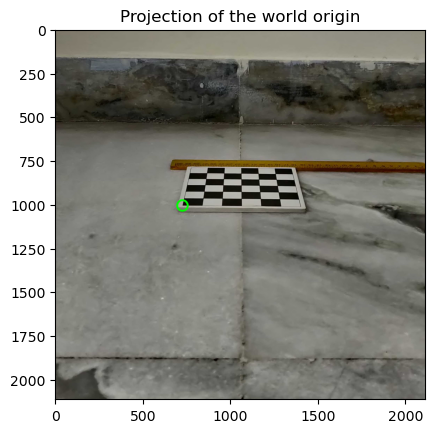

In [25]:
coord = P @ np.array([0, 0, 0, 1]).T
coord /= coord[2]

img2_copy = img2.copy()
drawPoints(img2_copy, coord[:2].astype(int), thickness=10)
display_image(img2_copy, title='Projection of the world origin')

**Observation**: The image of the World origin is the bottom-left corner seen from the top. This result agrees with our observation

# Task 3

## Task 3.1  Shifting the Chessboard Wireframe

Imagine that the chessboard in assign1.jpg was moved by 10 cm to the right (along the ruler).Overlay a wireframe of the virtual chessboard on the image at the appropriate location. Does the wireframe look consistent with what you expect?

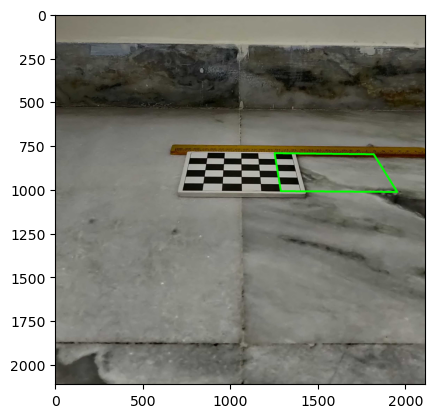

In [26]:
wireframe2_shifted_pts = np.array([[10, 0, 0],
                           [22, 0, 0],
                           [22, 12, 0],
                           [10, 12, 0]], dtype=np.float32)

wireframe2Coord = cv.projectPoints(wireframe2_shifted_pts, rotVec, transVec, K, distortion_coeff)[0]
plotWireFrame(wireframe2Coord.squeeze(), img2)

**Observation** : The wireframe although is fairly consistent but it does seems a little distorted (bending down towards its right end). This may possibly due to distortion in the orignal image.

## Task 3.2 Moving the Pixels

Now, think of how you would move the actual pixels or pattern of the chessboard? Overlay the chessboard pattern within the predicted wireframe. Is the overlay consistent with what you expect?

In [27]:
# Looping within the wireframe (thus creating a meshgrid of world coordinates).
x_coords = wireframe2_pts[:,0]
y_coords = wireframe2_pts[:,1]

# Sampling the Points
x, y = np.meshgrid(np.linspace(min(x_coords), max(x_coords), 500), np.linspace(min(y_coords), max(y_coords), 500))
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)
z = np.zeros_like(x)

board_coord = np.hstack((x, y, z))
projected_coord = cv.projectPoints(board_coord, rotVec, transVec, K, distortion_coeff)[0].squeeze()

board_coord[:, 0] += 10
projected_coord_shifted = cv.projectPoints(board_coord, rotVec, transVec, K, distortion_coeff)[0].squeeze()

In [28]:
# While copying pixels doing it from the right end
indices = np.argsort(x, axis=0)[::-1]
x = x[indices]
y = y[indices]
projected_coord = projected_coord[indices.squeeze()]
projected_coord_shifted = projected_coord_shifted[indices.squeeze()]

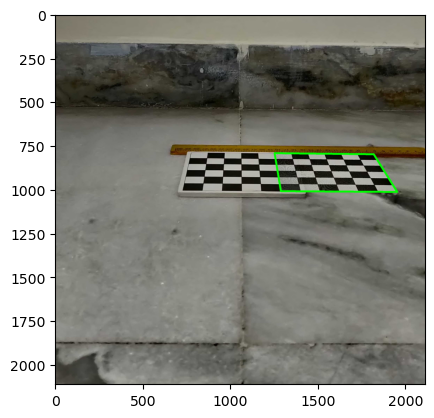

In [29]:
height, width = img2.shape[0], img2.shape[1]
wireframe_img = img2.copy()

for i in range(projected_coord_shifted.shape[0]):
    
    trans_u, trans_v = int(projected_coord_shifted[i][0]), int(projected_coord_shifted[i][1])
    
    u, v = int(projected_coord[i][0]), int(projected_coord[i][1])
    
    if (0 <= u < width and 0 <= v < height):
        wireframe_img[trans_v, trans_u] = wireframe_img[v, u]

        
plotWireFrame(wireframe2Coord.squeeze().copy(), wireframe_img)

**Observation**: My basic idea is to sample in the chessboard space i.e. sample real-world coordinates with the wireframe. We make the projection to them on to the image space using the calibrated camera.

Then we repeat the same process with x-values of each of those sample pointed shift by +10. We copy the corresponding pixel values for both the orignal and translated projection. Also we start copying from the right of the chessboard since we are shifting the chessboard to the right and there is some overlap between the orignal and the shifted.

## Challenges faced:



Some of the my challenges and learning were learning about OpenCV and its varies nuances. A particularly challenging part which I enjoyed, was writing own calibration function particulary the least-squared solution, RQ decomposition and towards the end shifting pixels (that was quite interesting).